In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
from tqdm.notebook import tqdm
import time
import gc

# Set random seed for reproducibility
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Clear GPU cache
torch.cuda.empty_cache()
gc.collect()

# Define data augmentation and preprocessing
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Load CIFAR-10 dataset with proper num_workers for Colab
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                      download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=128,
                        shuffle=True, num_workers=2,
                        pin_memory=True)  # Enable pin_memory for faster data transfer to GPU

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                     download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=128,
                       shuffle=False, num_workers=2,
                       pin_memory=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:12<00:00, 13.3MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [2]:
class HybridCNNMLP(nn.Module):
    def __init__(self):
        super(HybridCNNMLP, self).__init__()

        # CNN Feature Extractor
        self.conv_layers = nn.Sequential(
            # First convolutional block
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Second convolutional block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Third convolutional block
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Fourth convolutional block
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        # MLP Classifier
        self.mlp = nn.Sequential(
            nn.Flatten(),  # Flatten the CNN output
            nn.Linear(512 * 2 * 2, 1024),  # 512 channels * 2 * 2 spatial dimensions
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)  # 10 classes for CIFAR-10
        )

    def forward(self, x):
        # Extract features using CNN
        x = self.conv_layers(x)
        # Classify using MLP
        x = self.mlp(x)
        return x

# Create the model and move it to the device
model = HybridCNNMLP().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [3]:
def train_epoch(model, trainloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(trainloader, desc='Training'):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(trainloader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def evaluate(model, testloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(testloader, desc='Evaluating'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(testloader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

In [4]:
import matplotlib.pyplot as plt

# Lists to store metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

def plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies):
    plt.figure(figsize=(12, 5))

    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.grid(True)

    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracies')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Save the plots
    plt.savefig('training_metrics.png')


Epoch 1/20


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Training Loss: 1.5551, Training Accuracy: 42.05%


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 1.2172, Validation Accuracy: 57.01%
New best model saved with accuracy: 57.01%

Epoch 2/20


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Training Loss: 1.1548, Training Accuracy: 59.26%


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 0.9747, Validation Accuracy: 64.88%
New best model saved with accuracy: 64.88%

Epoch 3/20


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Training Loss: 0.9995, Training Accuracy: 65.46%


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 0.9013, Validation Accuracy: 68.83%
New best model saved with accuracy: 68.83%

Epoch 4/20


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Training Loss: 0.8948, Training Accuracy: 69.53%


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 0.8260, Validation Accuracy: 71.22%
New best model saved with accuracy: 71.22%

Epoch 5/20


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Training Loss: 0.8102, Training Accuracy: 72.67%


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 0.8225, Validation Accuracy: 72.39%
New best model saved with accuracy: 72.39%


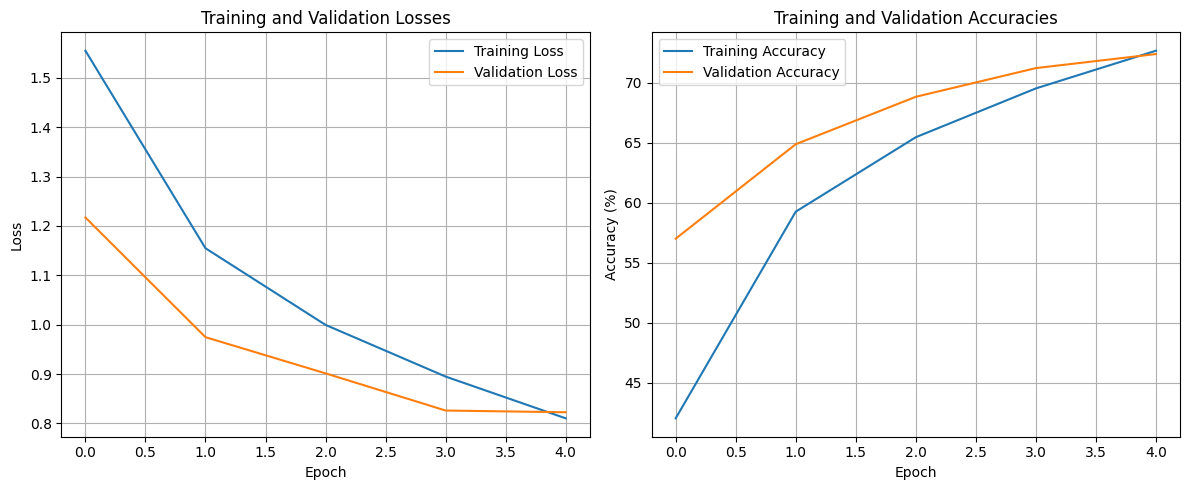


Epoch 6/20


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Training Loss: 0.7429, Training Accuracy: 75.18%


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 0.6874, Validation Accuracy: 76.81%
New best model saved with accuracy: 76.81%

Epoch 7/20


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Training Loss: 0.7010, Training Accuracy: 76.72%


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 0.6817, Validation Accuracy: 76.03%

Epoch 8/20


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Training Loss: 0.6531, Training Accuracy: 78.25%


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 0.5996, Validation Accuracy: 79.54%
New best model saved with accuracy: 79.54%

Epoch 9/20


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Training Loss: 0.6159, Training Accuracy: 79.61%


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 0.6254, Validation Accuracy: 78.31%

Epoch 10/20


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Training Loss: 0.5891, Training Accuracy: 80.44%


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 0.5852, Validation Accuracy: 80.20%
New best model saved with accuracy: 80.20%


<Figure size 640x480 with 0 Axes>

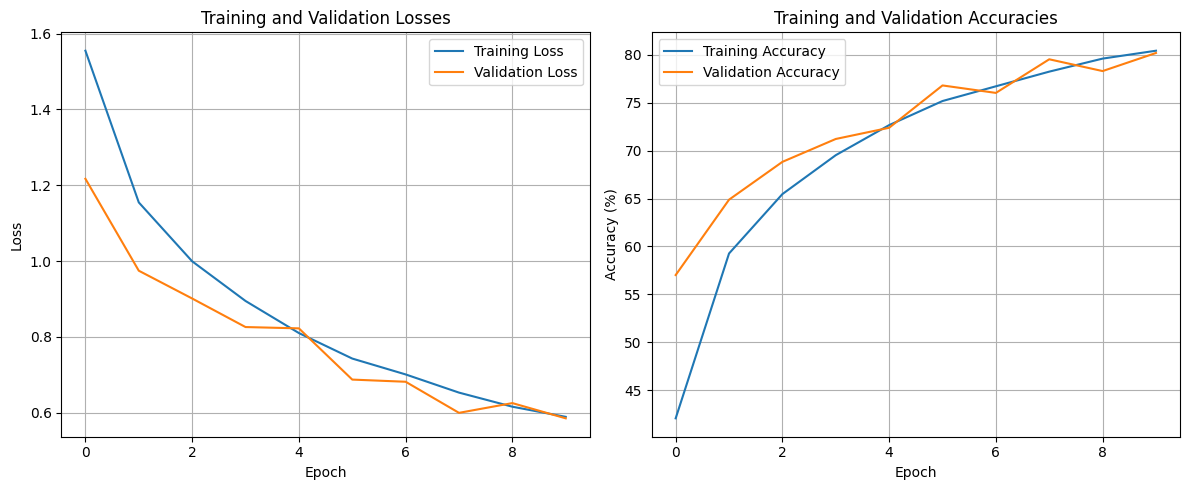


Epoch 11/20


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Training Loss: 0.5581, Training Accuracy: 81.63%


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 0.5648, Validation Accuracy: 80.34%
New best model saved with accuracy: 80.34%

Epoch 12/20


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Training Loss: 0.5289, Training Accuracy: 82.54%


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 0.5504, Validation Accuracy: 81.53%
New best model saved with accuracy: 81.53%

Epoch 13/20


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Training Loss: 0.5112, Training Accuracy: 83.13%


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 0.5300, Validation Accuracy: 81.78%
New best model saved with accuracy: 81.78%

Epoch 14/20


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Training Loss: 0.4819, Training Accuracy: 83.85%


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 0.4669, Validation Accuracy: 84.55%
New best model saved with accuracy: 84.55%

Epoch 15/20


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Training Loss: 0.4695, Training Accuracy: 84.37%


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 0.4768, Validation Accuracy: 83.77%


<Figure size 640x480 with 0 Axes>

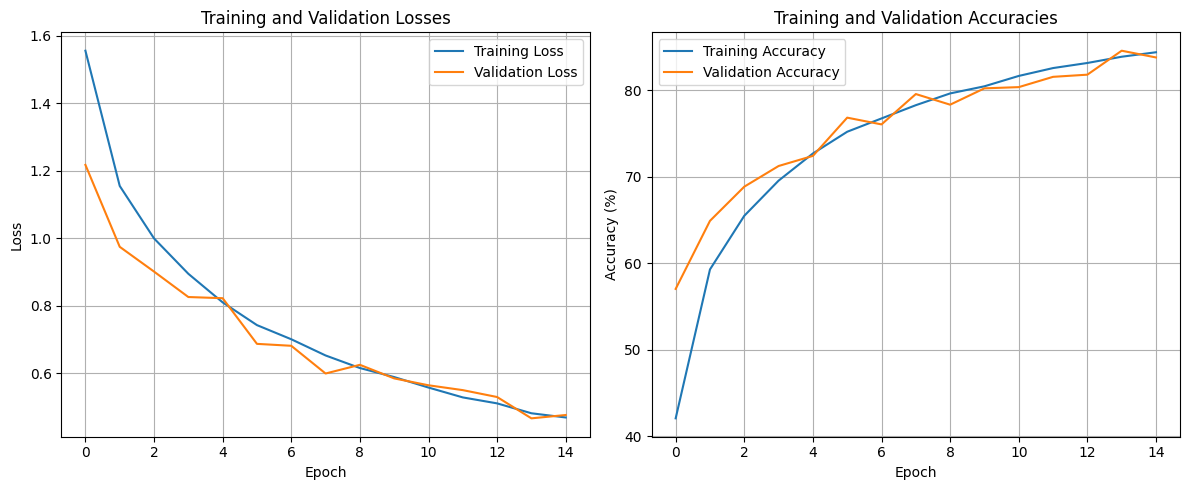


Epoch 16/20


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Training Loss: 0.4476, Training Accuracy: 85.11%


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 0.4752, Validation Accuracy: 83.92%

Epoch 17/20


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Training Loss: 0.4248, Training Accuracy: 85.94%


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 0.4749, Validation Accuracy: 83.91%

Epoch 18/20


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Training Loss: 0.4138, Training Accuracy: 86.28%


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 0.4499, Validation Accuracy: 84.67%
New best model saved with accuracy: 84.67%

Epoch 19/20


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Training Loss: 0.4005, Training Accuracy: 86.69%


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 0.4603, Validation Accuracy: 84.51%

Epoch 20/20


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Training Loss: 0.3881, Training Accuracy: 87.12%


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 0.4709, Validation Accuracy: 83.94%


<Figure size 640x480 with 0 Axes>

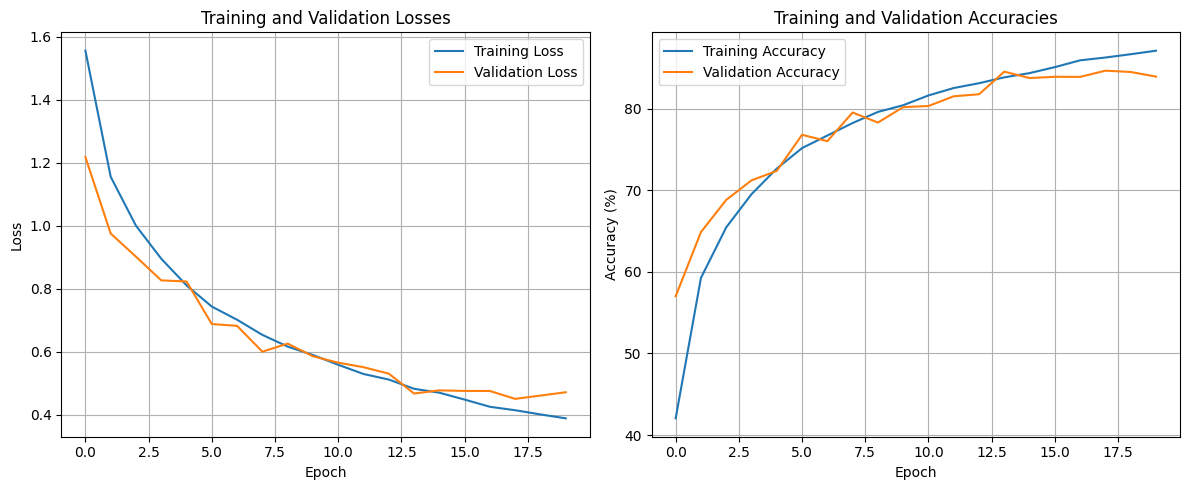


Best validation accuracy: 84.67%


<Figure size 640x480 with 0 Axes>

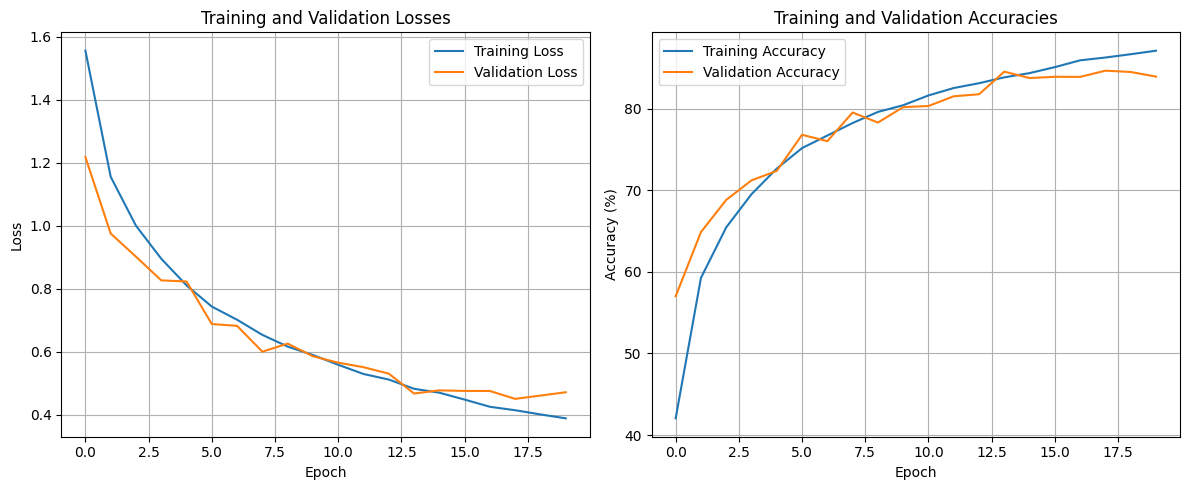

<Figure size 640x480 with 0 Axes>

In [5]:
# Training loop
num_epochs = 20
best_acc = 0
best_model = None

for epoch in range(num_epochs):
    print(f'\nEpoch {epoch+1}/{num_epochs}')

    # Train
    train_loss, train_acc = train_epoch(model, trainloader, criterion, optimizer, device)
    print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.2f}%')

    # Evaluate
    val_loss, val_acc = evaluate(model, testloader, criterion, device)
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%')

    # Store metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Learning rate scheduling
    scheduler.step(val_loss)

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        best_model = model.state_dict()
        print(f'New best model saved with accuracy: {best_acc:.2f}%')

    # Plot metrics after each epoch
    if (epoch + 1) % 5 == 0:  # Plot every 5 epochs
        plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies)

print(f'\nBest validation accuracy: {best_acc:.2f}%')

# Plot final metrics
plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies)

# Save the best model
torch.save(best_model, 'best_hybrid_cnn_mlp.pth')

# Save the metrics
import numpy as np
np.save('training_metrics.npy', {
    'train_losses': train_losses,
    'train_accuracies': train_accuracies,
    'val_losses': val_losses,
    'val_accuracies': val_accuracies
})

Evaluating model performance...


<ipython-input-6-b141efb1dcab>:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_hybrid_cnn_mlp.pth'))


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]


Model Performance Metrics:
Accuracy: 0.839
Precision: 0.851
Recall: 0.839
F1-Score: 0.841

Detailed Classification Report:
              precision    recall  f1-score   support

       plane      0.873     0.835     0.854      1000
         car      0.932     0.947     0.939      1000
        bird      0.887     0.704     0.785      1000
         cat      0.632     0.779     0.698      1000
        deer      0.867     0.801     0.833      1000
         dog      0.683     0.827     0.748      1000
        frog      0.874     0.887     0.880      1000
       horse      0.948     0.765     0.847      1000
        ship      0.890     0.942     0.915      1000
       truck      0.919     0.907     0.913      1000

    accuracy                          0.839     10000
   macro avg      0.851     0.839     0.841     10000
weighted avg      0.851     0.839     0.841     10000


Plotting confusion matrix...


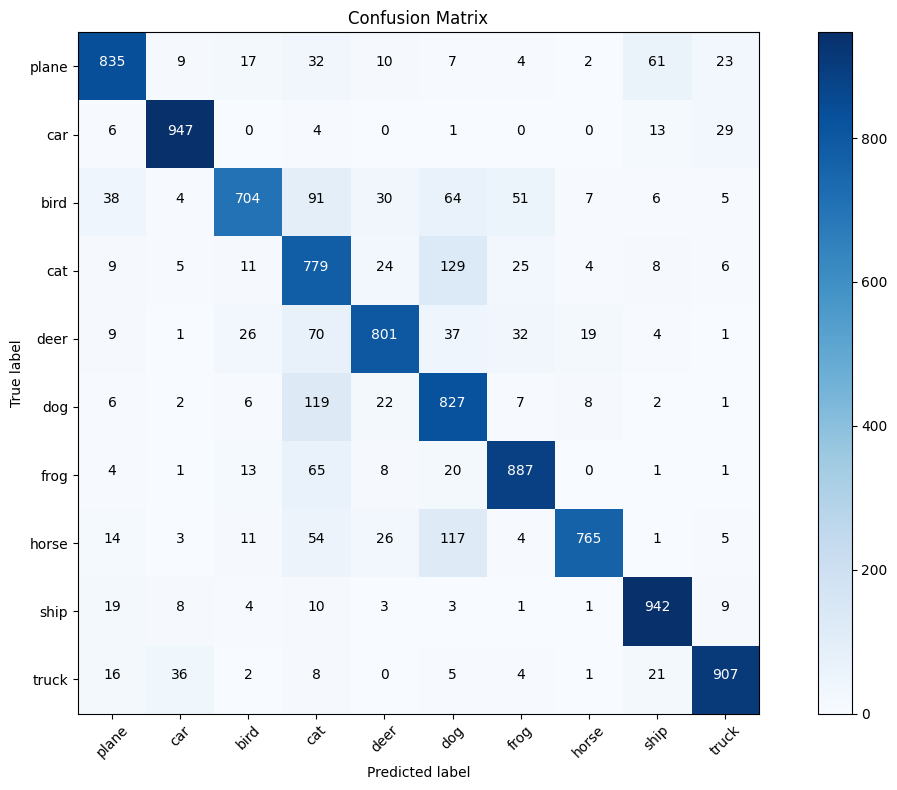

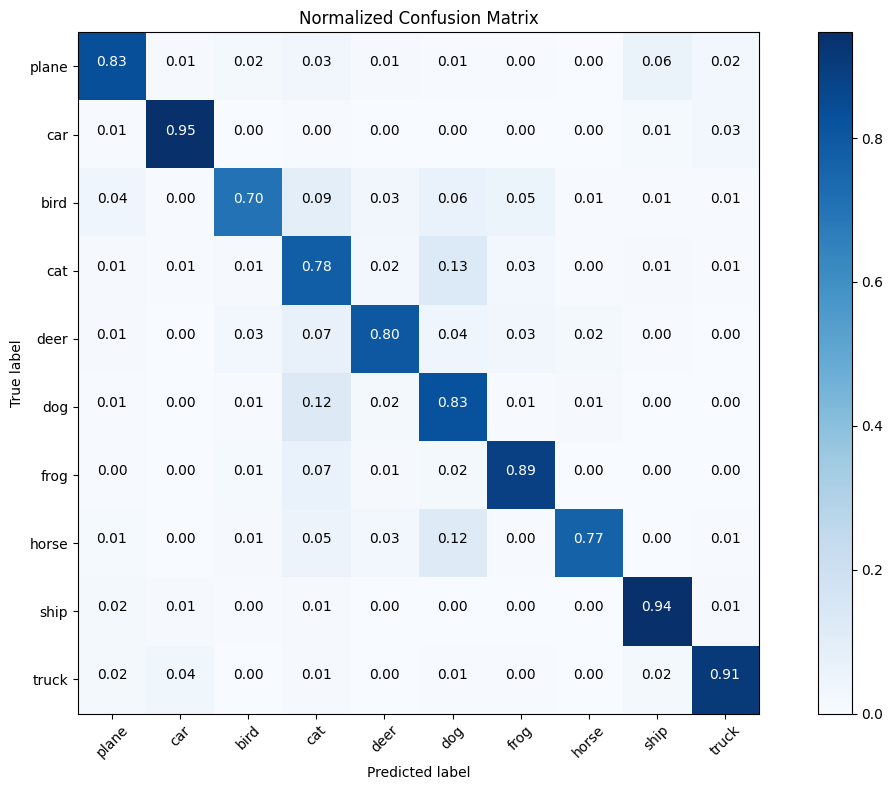


Visualizing sample predictions...


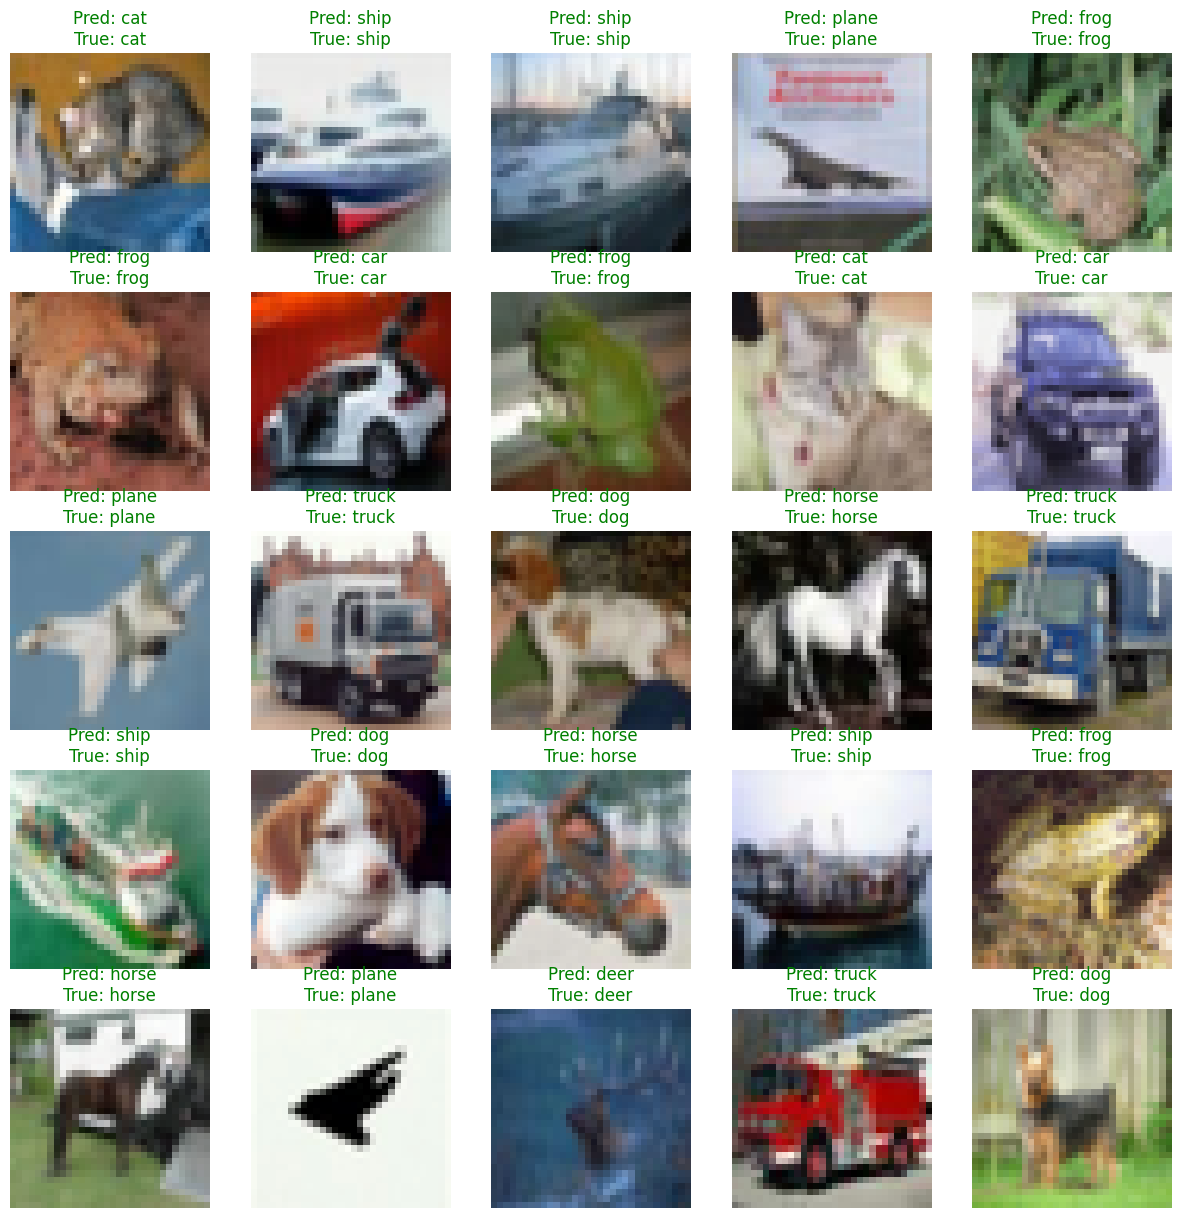

In [6]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import itertools

def evaluate_model(model, testloader, device, classes):
    model.eval()
    all_preds = []
    all_labels = []

    # Get predictions
    with torch.no_grad():
        for inputs, labels in tqdm(testloader, desc='Evaluating'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')

    # Get per-class metrics
    class_report = classification_report(all_labels, all_preds, target_names=classes, digits=3)

    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    return accuracy, precision, recall, f1, cm, class_report

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(12, 8))

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    # Add class labels
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Add number labels to the plot
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

    # Save the confusion matrix plot
    plt.savefig('confusion_matrix.png')
    plt.show()

def visualize_predictions(model, testloader, device, classes, num_images=25):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 15))

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                if images_so_far >= num_images:
                    return

                images_so_far += 1
                ax = plt.subplot(5, 5, images_so_far)
                ax.axis('off')
                ax.set_title(f'Pred: {classes[preds[j]]}\nTrue: {classes[labels[j]]}',
                           color=('green' if preds[j] == labels[j] else 'red'))

                # Denormalize the image
                img = inputs[j].cpu().numpy().transpose((1, 2, 0))
                mean = np.array([0.4914, 0.4822, 0.4465])
                std = np.array([0.2023, 0.1994, 0.2010])
                img = std * img + mean
                img = np.clip(img, 0, 1)

                plt.imshow(img)

                if images_so_far >= num_images:
                    break

    plt.savefig('prediction_samples.png')
    plt.show()

# Load the best model
model.load_state_dict(torch.load('best_hybrid_cnn_mlp.pth'))
model.to(device)

# Evaluate the model
print("Evaluating model performance...")
accuracy, precision, recall, f1, confusion_mat, class_report = evaluate_model(model, testloader, device, classes)

# Print metrics
print("\nModel Performance Metrics:")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.3f}")

print("\nDetailed Classification Report:")
print(class_report)

# Plot confusion matrix
print("\nPlotting confusion matrix...")
plot_confusion_matrix(confusion_mat, classes, normalize=False, title='Confusion Matrix')
plot_confusion_matrix(confusion_mat, classes, normalize=True, title='Normalized Confusion Matrix')

# Visualize some predictions
print("\nVisualizing sample predictions...")
visualize_predictions(model, testloader, device, classes)

# Save metrics to a file
with open('model_evaluation_metrics.txt', 'w') as f:
    f.write("Model Performance Metrics:\n")
    f.write(f"Accuracy: {accuracy:.3f}\n")
    f.write(f"Precision: {precision:.3f}\n")
    f.write(f"Recall: {recall:.3f}\n")
    f.write(f"F1-Score: {f1:.3f}\n\n")
    f.write("Detailed Classification Report:\n")
    f.write(class_report)